<a href="https://colab.research.google.com/github/federico-bassi/EtricsIII/blob/main/Part_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 - Part III

## Imports

In [ ]:
#Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ardl import ARDL, ardl_select_order
from statsmodels.tsa.stattools import adfuller
from google.colab import drive
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
import seaborn as sns
import scipy
from scipy import stats
from scipy.stats import norm
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import coint

drive.mount('/content/drive')
np.random.seed(1234)

Mounted at /content/drive


In [ ]:
who_are_you = 0
if who_are_you == 0:
  path = "/content/drive/MyDrive/EtricsIII_Ass2"
else:
  path = "..."

In [ ]:
#Load data
data = pd.read_csv(path+"/Data/data_assign_p4.csv")

In [ ]:
data.head()

,obs,CONS,INC,TIME
0,1988Q1,53803.3,69522.0,725736
1,1988Q2,54124.1,70033.3,725827
2,1988Q3,54383.8,70634.5,725918
3,1988Q4,54783.6,71321.8,726010
4,1989Q1,54980.6,72377.2,726102


## Point 1

In [ ]:
#Set up similation by choosing parameters and sample sizes
sigma2u = 3
sigma2v = 2
sample_sizes = [500, 1000, 5000]
num_simulations = 500
beta1 = {}
beta2 = {}
frac1 = {}
frac2 = {}
r_squared1 = {}
r_squared2 = {}
gamma= 0.5
phi = 0.5

for sample_size in sample_sizes:
    beta1[sample_size] = []
    frac1[sample_size] = []
    r_squared1[sample_size] = []

#Simulate data with first DGP
for sample_size in sample_sizes:
    for sim in range(num_simulations):
        u = np.random.normal(0, sigma2u, sample_size)
        v = np.random.normal(0, sigma2v, sample_size)
        Y = np.zeros(sample_size)
        X = np.zeros(sample_size)
        for i in range(1, sample_size):
            X[i] = X[i-1] + v[i]
            Y[i] = gamma * X[i] + u[i]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)
        beta1[sample_size].append(slope)
        frac1[sample_size].append(slope / std_err)
        r_squared1[sample_size].append(r_value**2)

for sample_size in sample_sizes:
    beta2[sample_size] = []
    frac2[sample_size] = []
    r_squared2[sample_size] = []

#Simulate data with second DGP
for sample_size in sample_sizes:
    for sim in range(num_simulations):
        u = np.random.normal(0, sigma2u, sample_size)
        v = np.random.normal(0, sigma2v, sample_size)
        Y = np.zeros(sample_size)
        X = np.zeros(sample_size)
        for i in range(1, sample_size):
            X[i] = phi * X[i-1] + v[i]
            Y[i] = gamma * X[i] + u[i]
        slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(X, Y)
        beta2[sample_size].append(slope)
        frac2[sample_size].append(slope / std_err)
        r_squared2[sample_size].append(r_value**2)

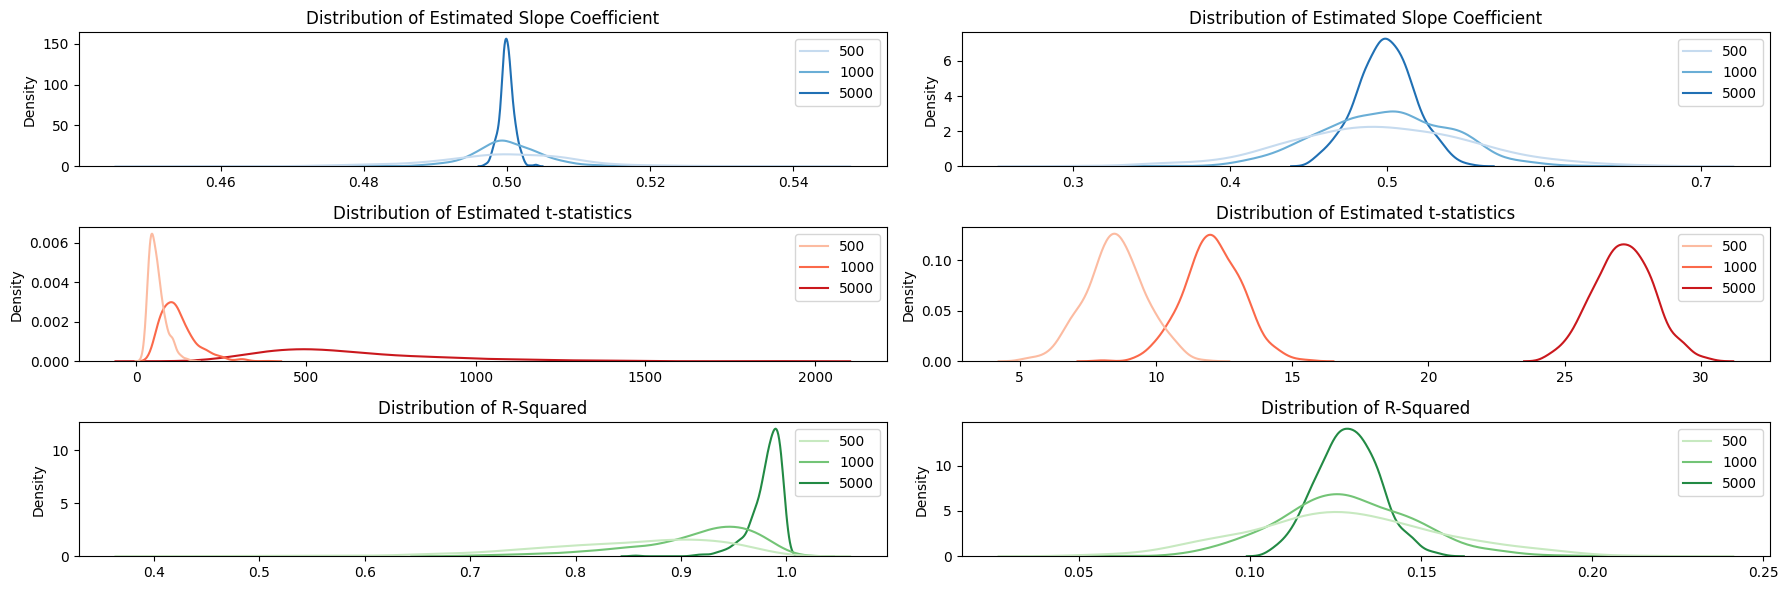

In [ ]:
#Plot distributions for slope coefficient1
fig, axes = plt.subplots(3, 2, figsize=(18, 6))
sns.kdeplot(data=beta1, palette='Blues', ax=axes[0,0])
axes[0,0].set_title('Distribution of Estimated Slope Coefficient')

#Plot distributions for slope coefficient2
sns.kdeplot(data=beta2, palette='Blues', ax=axes[0,1])
axes[0,1].set_title('Distribution of Estimated Slope Coefficient')

#Plot distributions for frac1
sns.kdeplot(data=frac1, palette='Reds', ax=axes[1,0])
axes[1,0].set_title('Distribution of Estimated t-statistics')

#Plot distributions for frac2
sns.kdeplot(data=frac2, palette='Reds', ax=axes[1,1])
axes[1,1].set_title('Distribution of Estimated t-statistics')

# Plot distributions for r squared1
sns.kdeplot(data=r_squared1, palette='Greens', ax=axes[2,0])
axes[2,0].set_title('Distribution of R-Squared')

# Plot distributions for r squared2
sns.kdeplot(data=r_squared2, palette='Greens', ax=axes[2,1])
axes[2,1].set_title('Distribution of R-Squared')

#Plot figures
plt.tight_layout()
plt.savefig(path+"/Figures/part4_monte_carlo")
plt.show()

## Point 2

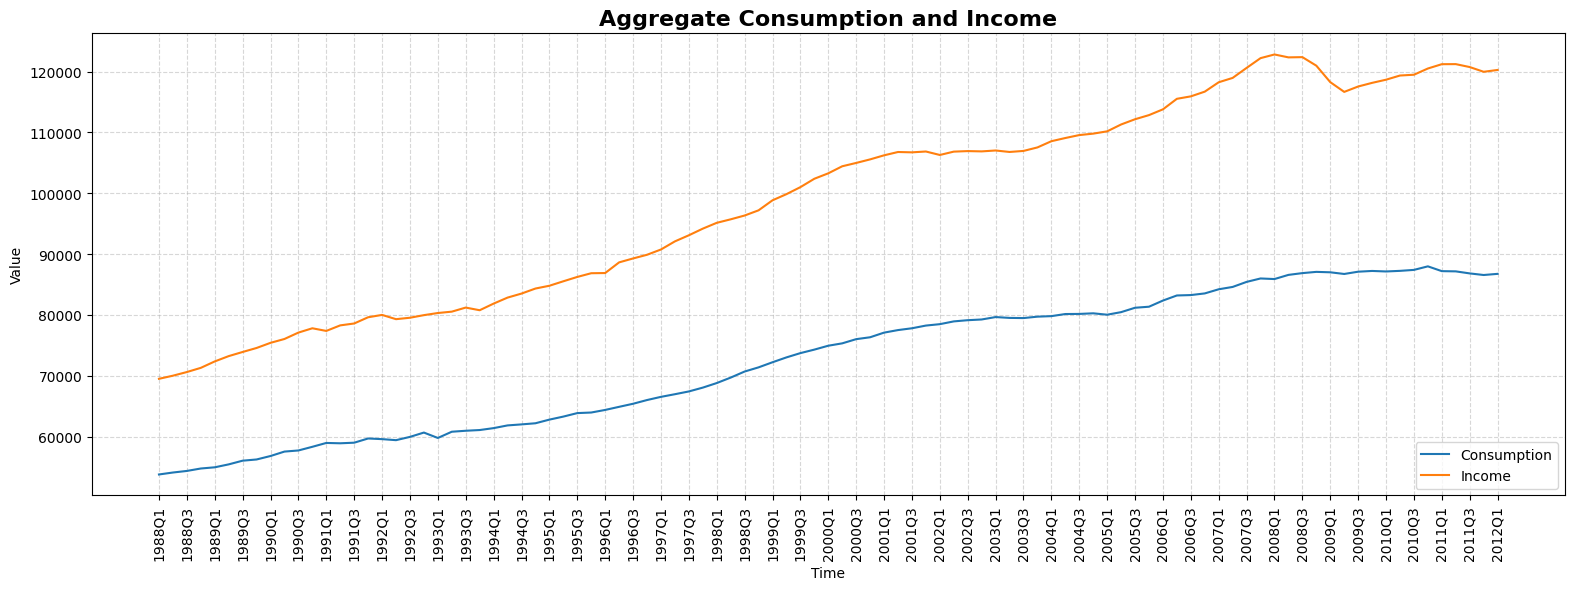

In [ ]:
#Plot aggregate consumption
plt.figure(figsize=(19, 6))

plt.plot(data['obs'], data['CONS'], label='Consumption')
plt.plot(data['obs'], data['INC'], label='Income')
plt.grid(True, linestyle='--', alpha=0.5)

#Add title and axis labels
plt.title('Aggregate Consumption and Income', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(data['obs'][::2], rotation=90)
plt.legend(loc='lower right')
plt.savefig("/content/drive/MyDrive/EtricsIII_Ass2/Figures/ConsumptionandIncome.png")
plt.show()

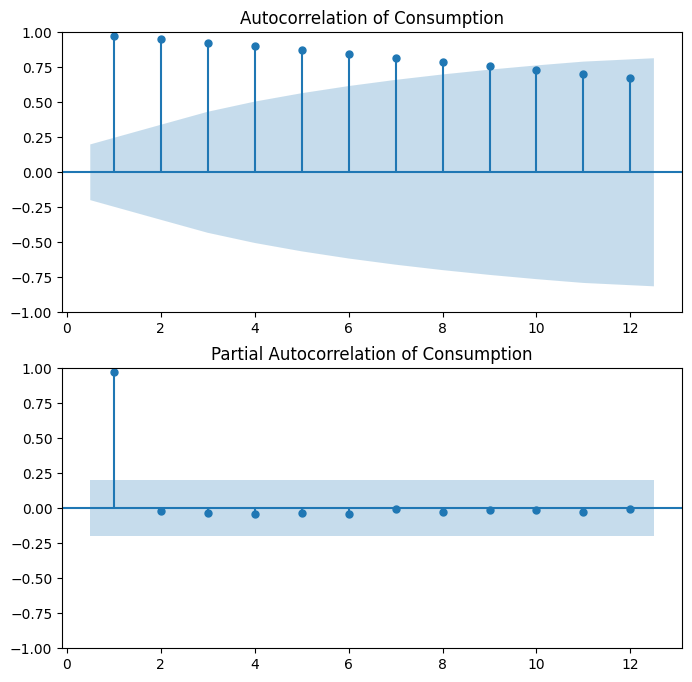

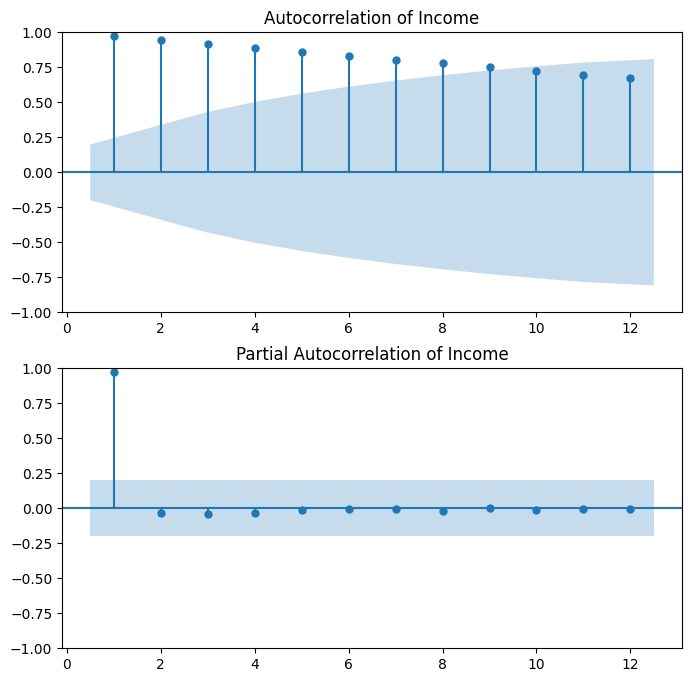

In [ ]:
#ACF and PACF Consumption
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(data["CONS"], lags=12, zero=False, ax=ax1)
ax1.set_title('Autocorrelation of Consumption', fontsize=12, color='black')
plot_pacf(data["CONS"], lags=12, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation of Consumption', fontsize=12, color='black')
plt.savefig("/content/drive/MyDrive/EtricsIII_Ass2/Figures/acfCONS.png")
plt.show()

#ACF and PACF Income
fig, (ax1,ax2) = plt.subplots(2,1, figsize=(8,8))
plot_acf(data["INC"], lags=12, zero=False, ax=ax1)
ax1.set_title('Autocorrelation of Income', fontsize=12, color='black')
plot_pacf(data["INC"], lags=12, zero=False, ax=ax2)
ax2.set_title('Partial Autocorrelation of Income', fontsize=12, color='black')
plt.savefig("/content/drive/MyDrive/EtricsIII_Ass2/Figures/acfINC.png")
plt.show()

## Point 3

In [ ]:
#Augmented Dickey Fuller test consumption, maxlag = 12, using SIC
adfuller(data["CONS"], 12, "ct", "bic")

(-0.838902305974484,
 0.9622451903074954,
 3,
 93,
 {'1%': -4.059568800656923,
  '5%': -3.4587997574833063,
  '10%': -3.1553337836930617},
 1234.2452990643972)

In [ ]:
#Augmented Dickey Fuller test income, maxlag = 12, using SIC
adfuller(data["INC"], 12, "ct", "bic")

(-1.3397416769414023,
 0.877745150152082,
 1,
 95,
 {'1%': -4.057372178160081,
  '5%': -3.4577588776789616,
  '10%': -3.154727848082811},
 1331.0779077077543)

In [ ]:
#Store test results to export to latex code
test_stat = {}
variables = {"CONS", "INC"}

for variable in variables:
    if variable == "CONS":
        x_T = data["CONS"]
    elif variable == "INC":
        x_T = data["INC"]

    results = adfuller(x_T, maxlag = 12, regression="ct", autolag="BIC")
    test_stat[variable] = results[0]

df = pd.DataFrame(test_stat.items(), columns=['Time Series', 'DF Test Statistic'])

In [ ]:
with open(path+"/Tables/part4.4_ADF.tex", 'w') as f:
    f.write(df.to_latex(index=False))

In [ ]:
#Take First Difference of consumption series and adjust index
differenced = data[["CONS"]].diff().dropna()
differenced.index = differenced.index - 1
differenced

,CONS
0,320.8
1,259.7
2,399.8
3,197.0
4,481.7
...,...
91,-788.0
92,-36.4
93,-335.2
94,-262.5


In [ ]:
#Store original (=non-differenced) data in variable
original =data[["CONS"]].iloc[:96]
original

,CONS
0,53803.3
1,54124.1
2,54383.8
3,54783.6
4,54980.6
...,...
91,88001.2
92,87213.2
93,87176.8
94,86841.6


In [ ]:
#G2S approach:
#ADL(12,0) using first differenced and original series (0th lag only)
adl_121 = ARDL(endog=differenced, lags=12, exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.057
Method:               Conditional MLE   S.D. of innovations            306.312
Date:                Thu, 11 Apr 2024   AIC                           1232.115
Time:                        17:17:34   BIC                           1271.008
Sample:                            12   HQIC                          1247.750
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1413.7071   1798.955      0.786      0.435   -2175.110    5002.524
trend          8.0539     15.080      0.534      0.595     -22.029      38.137
CONS.L1       -0.0293      0.123     -0.237      0.8

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[1,2,3,4,5,6,7,8,9,11,12], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.062
Method:               Conditional MLE   S.D. of innovations            306.330
Date:                Thu, 11 Apr 2024   AIC                           1230.125
Time:                        17:17:34   BIC                           1266.587
Sample:                            12   HQIC                          1244.782
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1459.0803   1714.772      0.851      0.398   -1960.925    4879.085
trend          8.4479     14.329      0.590      0.557     -20.131      37.027
CONS.L1       -0.0283      0.122     -0.232      0.8

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[1,2,3,4,5,6,7,8,11,12], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.071
Method:               Conditional MLE   S.D. of innovations            306.360
Date:                Thu, 11 Apr 2024   AIC                           1228.142
Time:                        17:17:34   BIC                           1262.173
Sample:                            12   HQIC                          1241.822
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1424.8771   1678.488      0.849      0.399   -1921.933    4771.687
trend          8.1559     14.017      0.582      0.563     -19.794      36.105
CONS.L1       -0.0293      0.121     -0.242      0.8

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[1,2,3,4,5,6,7,11,12], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.085
Method:               Conditional MLE   S.D. of innovations            306.413
Date:                Thu, 11 Apr 2024   AIC                           1226.170
Time:                        17:17:34   BIC                           1257.771
Sample:                            12   HQIC                          1238.874
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1473.2597   1638.334      0.899      0.372   -1792.699    4739.218
trend          8.5679     13.672      0.627      0.533     -18.687      35.823
CONS.L1       -0.0308      0.120     -0.257      0.7

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4,5,6,7,11,12], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.124
Method:               Conditional MLE   S.D. of innovations            306.554
Date:                Thu, 11 Apr 2024   AIC                           1224.248
Time:                        17:17:35   BIC                           1253.417
Sample:                            12   HQIC                          1235.974
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1559.2201   1593.644      0.978      0.331   -1616.909    4735.349
trend          9.3948     13.204      0.712      0.479     -16.921      35.711
CONS.L2        0.1616      0.115      1.400      0.1

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4,6,7,11,12], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -600.159
Method:               Conditional MLE   S.D. of innovations            306.682
Date:                Thu, 11 Apr 2024   AIC                           1222.318
Time:                        17:17:35   BIC                           1249.057
Sample:                            12   HQIC                          1233.067
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1509.6076   1570.930      0.961      0.340   -1620.539    4639.754
trend          8.9443     12.995      0.688      0.493     -16.949      34.837
CONS.L2        0.1719      0.107      1.608      0.1

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4,6,7,11], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(11, 0)   Log Likelihood                -606.891
Method:               Conditional MLE   S.D. of innovations            305.195
Date:                Thu, 11 Apr 2024   AIC                           1233.781
Time:                        17:17:35   BIC                           1258.208
Sample:                            11   HQIC                          1243.606
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1660.0127   1470.701      1.129      0.263   -1269.143    4589.168
trend         10.1597     12.074      0.841      0.403     -13.888      34.207
CONS.L2        0.1709      0.105      1.631      0.1

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4,7,11], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(11, 0)   Log Likelihood                -607.143
Method:               Conditional MLE   S.D. of innovations            306.103
Date:                Thu, 11 Apr 2024   AIC                           1232.286
Time:                        17:17:35   BIC                           1254.270
Sample:                            11   HQIC                          1241.129
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1401.7065   1414.695      0.991      0.325   -1415.310    4218.723
trend          7.9300     11.569      0.685      0.495     -15.108      30.968
CONS.L2        0.1785      0.104      1.720      0.0

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4,11], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                    ARDL(11, 0)   Log Likelihood                -607.970
Method:               Conditional MLE   S.D. of innovations            309.095
Date:                Thu, 11 Apr 2024   AIC                           1231.940
Time:                        17:17:35   BIC                           1251.481
Sample:                            11   HQIC                          1239.800
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        968.7358   1374.689      0.705      0.483   -1768.059    3705.530
trend          4.1785     11.197      0.373      0.710     -18.112      26.469
CONS.L2        0.1676      0.104      1.615      0.1

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[2,3,4], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                     ARDL(4, 0)   Log Likelihood                -656.677
Method:               Conditional MLE   S.D. of innovations            304.557
Date:                Thu, 11 Apr 2024   AIC                           1327.355
Time:                        17:17:35   BIC                           1345.007
Sample:                             4   HQIC                          1334.479
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1755.2859   1226.084      1.432      0.156    -682.089    4192.661
trend         10.4288      9.767      1.068      0.289      -8.988      29.845
CONS.L2        0.1609      0.100      1.611      0.1

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[3,4], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                     ARDL(4, 0)   Log Likelihood                -658.045
Method:               Conditional MLE   S.D. of innovations            309.118
Date:                Thu, 11 Apr 2024   AIC                           1328.090
Time:                        17:17:35   BIC                           1343.220
Sample:                             4   HQIC                          1334.197
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1310.3178   1205.468      1.087      0.280   -1085.680    3706.316
trend          6.1101      9.478      0.645      0.521     -12.728      24.948
CONS.L3        0.4530      0.102      4.460      0.0

In [ ]:
adl_121 = ARDL(endog=differenced, lags=[3], exog=original, order=[0], trend='ct')
adl_121_result = adl_121.fit()
print(adl_121_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   96
Model:                     ARDL(3, 0)   Log Likelihood                -666.768
Method:               Conditional MLE   S.D. of innovations            314.382
Date:                Thu, 11 Apr 2024   AIC                           1343.536
Time:                        22:00:07   BIC                           1356.199
Sample:                             3   HQIC                          1348.649
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        567.7441   1147.748      0.495      0.622   -1712.806    2848.294
trend         -0.2773      8.841     -0.031      0.975     -17.844      17.290
CONS.L3        0.4511      0.103      4.401      0.0

In [ ]:
#Export the results for AR on Latex
res_ar = summary_col([adl_121_result],stars=True,float_format='%0.2f')
f = open('/content/drive/MyDrive/EtricsIII_Ass2/Tables/4.4ADLConsumption.tex', 'w')
f.write(res_ar.as_latex())
f.close()

Income


In [ ]:
#Take first difference of income series, and adjust index, and store original series of income in variable
differenced2 = data[["INC"]].diff().dropna()
differenced2.index = differenced2.index - 1
differenced2
original2 =data[["INC"]].iloc[:96]
original2

,INC
0,69522.0
1,70033.3
2,70634.5
3,71321.8
4,72377.2
...,...
91,120510.3
92,121219.3
93,121229.9
94,120748.0


In [ ]:
#G2S approach:
#ADL(12,0) using first differenced and original series (0th lag only)
adl_2 = ARDL(endog=differenced2, lags=[1,2,3,4,5,6,7,8,9,10,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.369
Method:               Conditional MLE   S.D. of innovations            550.952
Date:                Thu, 11 Apr 2024   AIC                           1330.738
Time:                        17:17:35   BIC                           1369.631
Sample:                            12   HQIC                          1346.373
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4173.9023   3252.615      1.283      0.204   -2314.888    1.07e+04
trend         31.5332     32.061      0.984      0.329     -32.427      95.494
INC.L1         0.5589      0.117      4.796      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,2,3,4,6,7,8,9,10,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.369
Method:               Conditional MLE   S.D. of innovations            550.952
Date:                Thu, 11 Apr 2024   AIC                           1328.739
Time:                        17:17:35   BIC                           1365.201
Sample:                            12   HQIC                          1343.396
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4184.0633   3134.748      1.335      0.186   -2067.995    1.04e+04
trend         31.6368     30.833      1.026      0.308     -29.857      93.131
INC.L1         0.5590      0.115      4.857      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,4,6,7,8,9,10,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.378
Method:               Conditional MLE   S.D. of innovations            551.009
Date:                Thu, 11 Apr 2024   AIC                           1326.756
Time:                        17:17:35   BIC                           1360.787
Sample:                            12   HQIC                          1340.436
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4291.3054   2983.960      1.438      0.155   -1658.542    1.02e+04
trend         32.7283     29.258      1.119      0.267     -25.611      91.067
INC.L1         0.5540      0.106      5.209      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,4,6,7,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.459
Method:               Conditional MLE   S.D. of innovations            551.540
Date:                Thu, 11 Apr 2024   AIC                           1324.918
Time:                        17:17:35   BIC                           1356.518
Sample:                            12   HQIC                          1337.621
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4455.8714   2932.891      1.519      0.133   -1390.740    1.03e+04
trend         34.4195     28.725      1.198      0.235     -22.843      91.682
INC.L1         0.5517      0.106      5.228      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,4,6,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.560
Method:               Conditional MLE   S.D. of innovations            552.207
Date:                Thu, 11 Apr 2024   AIC                           1323.121
Time:                        17:17:36   BIC                           1352.291
Sample:                            12   HQIC                          1334.847
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4726.6660   2844.017      1.662      0.101    -941.451    1.04e+04
trend         37.1794     27.795      1.338      0.185     -18.216      92.575
INC.L1         0.5555      0.105      5.313      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,4,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.655
Method:               Conditional MLE   S.D. of innovations            552.832
Date:                Thu, 11 Apr 2024   AIC                           1321.311
Time:                        17:17:36   BIC                           1348.050
Sample:                            12   HQIC                          1332.060
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4222.6735   2545.420      1.659      0.101    -849.186    9294.533
trend         32.0415     24.619      1.301      0.197     -17.013      81.096
INC.L1         0.5462      0.101      5.383      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -649.763
Method:               Conditional MLE   S.D. of innovations            553.538
Date:                Thu, 11 Apr 2024   AIC                           1319.525
Time:                        17:17:36   BIC                           1343.833
Sample:                            12   HQIC                          1329.297
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4678.8558   2306.680      2.028      0.046      83.714    9273.997
trend         36.6663     22.084      1.660      0.101      -7.327      80.659
INC.L1         0.5491      0.101      5.454      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,9,11,12], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(12, 0)   Log Likelihood                -650.894
Method:               Conditional MLE   S.D. of innovations            561.047
Date:                Thu, 11 Apr 2024   AIC                           1319.789
Time:                        17:17:36   BIC                           1341.666
Sample:                            12   HQIC                          1328.583
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5855.8791   2169.931      2.699      0.009    1534.087    1.02e+04
trend         48.7349     20.551      2.371      0.020       7.804      89.666
INC.L1         0.5735      0.100      5.740      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,9,11], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                    ARDL(11, 0)   Log Likelihood                -661.704
Method:               Conditional MLE   S.D. of innovations            581.618
Date:                Thu, 11 Apr 2024   AIC                           1339.408
Time:                        17:17:36   BIC                           1358.949
Sample:                            11   HQIC                          1347.268
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6481.5576   2218.725      2.921      0.005    2064.416    1.09e+04
trend         56.6215     20.919      2.707      0.008      14.976      98.267
INC.L1         0.5785      0.103      5.626      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,3,9], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                     ARDL(9, 0)   Log Likelihood                -677.653
Method:               Conditional MLE   S.D. of innovations            584.163
Date:                Thu, 11 Apr 2024   AIC                           1369.307
Time:                        17:17:36   BIC                           1386.568
Sample:                             9   HQIC                          1376.257
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5087.0500   1980.369      2.569      0.012    1146.737    9027.363
trend         41.7760     18.156      2.301      0.024       5.650      77.902
INC.L1         0.5684      0.102      5.556      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1,9], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                     ARDL(9, 0)   Log Likelihood                -678.811
Method:               Conditional MLE   S.D. of innovations            591.990
Date:                Thu, 11 Apr 2024   AIC                           1369.623
Time:                        17:17:36   BIC                           1384.418
Sample:                             9   HQIC                          1375.580
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4050.2924   1865.367      2.171      0.033     339.484    7761.101
trend         31.3123     16.840      1.859      0.067      -2.188      64.813
INC.L1         0.5852      0.102      5.715      0.0

In [ ]:
adl_2 = ARDL(endog=differenced2, lags=[1], exog=original2, order=[0], trend='ct')
adl_2_result = adl_2.fit()
print(adl_2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   96
Model:                     ARDL(1, 0)   Log Likelihood                -739.368
Method:               Conditional MLE   S.D. of innovations            580.493
Date:                Thu, 11 Apr 2024   AIC                           1488.735
Time:                        22:00:32   BIC                           1501.504
Sample:                             1   HQIC                          1493.895
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2608.5976   1646.898      1.584      0.117    -662.763    5879.959
trend         16.1841     14.398      1.124      0.264     -12.417      44.785
INC.L1         0.5209      0.094      5.539      0.0

In [ ]:
#Export the results for AR on Latex
res_ar = summary_col([adl_2_result],stars=True,float_format='%0.2f')
f = open('/content/drive/MyDrive/EtricsIII_Ass2/Tables/4.4ADLIncome.tex', 'w')
f.write(res_ar.as_latex())
f.close()

## Point 4

In [ ]:
#Store ADL test results on first differenced series
test_stat = {}
variables = {"CONS", "INC"}

for variable in variables:
    if variable == "CONS":
        x_T = data[["CONS"]].diff().dropna()
    elif variable == "INC":
        x_T = data[["INC"]].diff().dropna()

    results = adfuller(x_T, maxlag = 12, regression="ct", autolag="BIC")
    test_stat[variable] = results[0]

df = pd.DataFrame(test_stat.items(), columns=['Time Series', 'DF Test Statistic'])


In [ ]:
#Export as Latex code
with open(path+"/Tables/part4.4_ADF2.tex", 'w') as f:
    f.write(df.to_latex(index=False))

In [ ]:
#Print ADF test results differenced consumption series
results = adfuller(data[["CONS"]].diff().dropna(), maxlag = 12, regression="ct", autolag="BIC")
results

(-2.7697644202834995,
 0.2082711313711682,
 2,
 93,
 {'1%': -4.059568800656923,
  '5%': -3.4587997574833063,
  '10%': -3.1553337836930617},
 1215.035821501686)

In [ ]:
#Print ADF test results differenced income series
results = adfuller(data[["INC"]].diff().dropna(), maxlag = 12, regression="ct", autolag="BIC")
results

(-5.640105281816051,
 1.2104862606710897e-05,
 0,
 95,
 {'1%': -4.057372178160081,
  '5%': -3.4577588776789616,
  '10%': -3.154727848082811},
 1312.0646391776593)

In [ ]:
#Take first difference of consumption series and adjust index
differenced = data[["CONS"]].diff().dropna()
differenced.index = differenced.index - 1

#Store original series
original =data[["CONS"]].iloc[:96]

#Take second difference of consumption series and adjust index
differenced2 = differenced.diff().dropna()
differenced2.index = differenced2.index - 1

#Take first difference original series and adjust index
original2 =original.diff().dropna()
original2.index = original2.index - 1

ADL Consumption


In [ ]:
#G2S: Set up ADL(12,0)
adl_CONS2 = ARDL(endog=differenced2, lags=12, exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -592.050
Method:               Conditional MLE   S.D. of innovations            303.139
Date:                Thu, 11 Apr 2024   AIC                           1216.099
Time:                        19:33:25   BIC                           1254.801
Sample:                            12   HQIC                          1231.647
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        286.4447    142.695      2.007      0.049       1.701     571.189
trend         -2.1379      1.616     -1.323      0.190      -5.363       1.087
CONS.L1       -0.5330      0.243     -2.190      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=11, exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(11, 0)   Log Likelihood                -600.313
Method:               Conditional MLE   S.D. of innovations            307.246
Date:                Thu, 11 Apr 2024   AIC                           1230.626
Time:                        19:33:31   BIC                           1267.089
Sample:                            11   HQIC                          1245.284
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        247.7423    138.116      1.794      0.077     -27.722     523.206
trend         -1.6796      1.599     -1.050      0.297      -4.869       1.510
CONS.L1       -0.5531      0.231     -2.392      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,4,5,6,7,8,9,10,11], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(11, 0)   Log Likelihood                -600.343
Method:               Conditional MLE   S.D. of innovations            307.356
Date:                Thu, 11 Apr 2024   AIC                           1228.687
Time:                        19:33:53   BIC                           1262.718
Sample:                            11   HQIC                          1242.367
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        261.6047    122.667      2.133      0.036      17.013     506.196
trend         -1.6943      1.587     -1.068      0.289      -4.859       1.470
CONS.L1       -0.5146      0.154     -3.346      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,4,5,6,7,8,9,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -607.223
Method:               Conditional MLE   S.D. of innovations            306.389
Date:                Thu, 11 Apr 2024   AIC                           1240.445
Time:                        19:34:05   BIC                           1272.200
Sample:                            10   HQIC                          1253.218
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        253.1225    118.479      2.136      0.036      16.994     489.251
trend         -1.7297      1.546     -1.119      0.267      -4.810       1.351
CONS.L1       -0.5286      0.150     -3.518      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,4,6,7,8,9,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -607.646
Method:               Conditional MLE   S.D. of innovations            307.921
Date:                Thu, 11 Apr 2024   AIC                           1239.293
Time:                        19:34:18   BIC                           1268.605
Sample:                            10   HQIC                          1251.083
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        241.8712    117.533      2.058      0.043       7.681     476.061
trend         -1.7271      1.543     -1.119      0.267      -4.802       1.347
CONS.L1       -0.5331      0.150     -3.557      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,4,7,8,9,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -607.862
Method:               Conditional MLE   S.D. of innovations            308.704
Date:                Thu, 11 Apr 2024   AIC                           1237.725
Time:                        19:34:27   BIC                           1264.594
Sample:                            10   HQIC                          1248.532
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        234.6356    116.454      2.015      0.048       2.648     466.623
trend         -1.7339      1.537     -1.128      0.263      -4.795       1.327
CONS.L1       -0.5563      0.144     -3.852      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,7,8,9,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -608.243
Method:               Conditional MLE   S.D. of innovations            310.088
Date:                Thu, 11 Apr 2024   AIC                           1236.485
Time:                        19:34:39   BIC                           1260.912
Sample:                            10   HQIC                          1246.310
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.5828    116.148      2.046      0.044       6.253     468.913
trend         -1.7951      1.531     -1.172      0.245      -4.845       1.255
CONS.L1       -0.5388      0.143     -3.780      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,7,9,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -608.940
Method:               Conditional MLE   S.D. of innovations            312.644
Date:                Thu, 11 Apr 2024   AIC                           1235.880
Time:                        19:34:49   BIC                           1257.864
Sample:                            10   HQIC                          1244.723
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        224.6529    115.768      1.941      0.056      -5.871     455.177
trend         -1.8248      1.534     -1.190      0.238      -4.879       1.229
CONS.L1       -0.5513      0.142     -3.873      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,7,10], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                    ARDL(10, 0)   Log Likelihood                -609.060
Method:               Conditional MLE   S.D. of innovations            313.083
Date:                Thu, 11 Apr 2024   AIC                           1234.119
Time:                        19:34:58   BIC                           1253.661
Sample:                            10   HQIC                          1241.979
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        222.1851    115.065      1.931      0.057      -6.891     451.261
trend         -1.8261      1.526     -1.197      0.235      -4.864       1.212
CONS.L1       -0.5656      0.138     -4.092      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2,7], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                     ARDL(7, 0)   Log Likelihood                -630.112
Method:               Conditional MLE   S.D. of innovations            311.508
Date:                Thu, 11 Apr 2024   AIC                           1274.224
Time:                        19:35:05   BIC                           1291.565
Sample:                             7   HQIC                          1281.210
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        224.9050    109.476      2.054      0.043       7.123     442.687
trend         -1.8859      1.438     -1.312      0.193      -4.746       0.974
CONS.L1       -0.5768      0.135     -4.260      0.0

In [ ]:
adl_CONS2 = ARDL(endog=differenced2, lags=[1,2], exog=original2, order=[0], trend='ct')
adl_CONS2_result = adl_CONS2.fit()
print(adl_CONS2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                   CONS   No. Observations:                   95
Model:                     ARDL(2, 0)   Log Likelihood                -665.378
Method:               Conditional MLE   S.D. of innovations            309.719
Date:                Thu, 11 Apr 2024   AIC                           1342.757
Time:                        22:02:13   BIC                           1357.952
Sample:                             2   HQIC                          1348.892
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        223.3336     98.850      2.259      0.026      26.889     419.778
trend         -1.8787      1.296     -1.450      0.151      -4.454       0.696
CONS.L1       -0.5790      0.132     -4.376      0.0

In [ ]:
#Export the results for AR on Latex
res_ar = summary_col([adl_CONS2_result],stars=True,float_format='%0.2f')
f = open('/content/drive/MyDrive/EtricsIII_Ass2/Tables/DoubleDiffCons4.4.tex', 'w')
f.write(res_ar.as_latex())
f.close()

In [ ]:
#Take first difference original series and adjust index
differenced = data[["INC"]].diff().dropna()
differenced.index = differenced.index - 1

#Store original series
original =data[["INC"]].iloc[:96]

#Take second difference original series and adjust index
differenced2 = differenced.diff().dropna()
differenced2.index = differenced2.index - 1

#Take first difference original series and adjust index
original2 =original.diff().dropna()
original2.index = original2.index - 1

#G2S: Set up ADL(12,0)
adl_INC2 = ARDL(endog=differenced2, lags=12, exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -641.863
Method:               Conditional MLE   S.D. of innovations            552.445
Date:                Thu, 11 Apr 2024   AIC                           1315.727
Time:                        22:02:17   BIC                           1354.428
Sample:                            12   HQIC                          1331.275
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        476.7760    250.839      1.901      0.062     -23.766     977.318
trend         -3.1921      2.990     -1.068      0.289      -9.159       2.775
INC.L1         0.1678      0.237      0.707      0.4

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,2,3,4,5,6,8,9,10,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -641.905
Method:               Conditional MLE   S.D. of innovations            552.726
Date:                Thu, 11 Apr 2024   AIC                           1313.811
Time:                        19:38:33   BIC                           1350.094
Sample:                            12   HQIC                          1328.387
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        442.6892    213.310      2.075      0.042      17.147     868.232
trend         -3.0502      2.921     -1.044      0.300      -8.878       2.777
INC.L1         0.1261      0.176      0.718      0.4

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,2,3,4,5,6,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -641.923
Method:               Conditional MLE   S.D. of innovations            552.840
Date:                Thu, 11 Apr 2024   AIC                           1311.845
Time:                        19:38:42   BIC                           1345.709
Sample:                            12   HQIC                          1325.450
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        438.3762    210.301      2.085      0.041      18.945     857.808
trend         -3.0508      2.901     -1.052      0.297      -8.836       2.735
INC.L1         0.1213      0.172      0.705      0.4

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,3,4,5,6,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -641.952
Method:               Conditional MLE   S.D. of innovations            553.037
Date:                Thu, 11 Apr 2024   AIC                           1309.904
Time:                        19:38:59   BIC                           1341.349
Sample:                            12   HQIC                          1322.537
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        418.0436    188.355      2.219      0.030      42.474     793.613
trend         -2.9475      2.844     -1.036      0.304      -8.619       2.724
INC.L1         0.0942      0.121      0.776      0.4

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,3,4,6,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -642.114
Method:               Conditional MLE   S.D. of innovations            554.116
Date:                Thu, 11 Apr 2024   AIC                           1308.228
Time:                        19:39:12   BIC                           1337.254
Sample:                            12   HQIC                          1319.889
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        401.4176    184.754      2.173      0.033      33.118     769.718
trend         -2.8261      2.821     -1.002      0.320      -8.449       2.797
INC.L1         0.0779      0.117      0.667      0.5

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,3,6,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -642.191
Method:               Conditional MLE   S.D. of innovations            554.631
Date:                Thu, 11 Apr 2024   AIC                           1306.382
Time:                        19:39:25   BIC                           1332.989
Sample:                            12   HQIC                          1317.071
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        395.1719    182.870      2.161      0.034      30.712     759.632
trend         -2.8112      2.804     -1.003      0.319      -8.399       2.777
INC.L1         0.0737      0.116      0.637      0.5

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[1,3,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -642.358
Method:               Conditional MLE   S.D. of innovations            555.745
Date:                Thu, 11 Apr 2024   AIC                           1304.715
Time:                        19:39:38   BIC                           1328.903
Sample:                            12   HQIC                          1314.433
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        392.3578    181.921      2.157      0.034      29.871     754.844
trend         -2.8213      2.790     -1.011      0.315      -8.381       2.738
INC.L1         0.0654      0.114      0.574      0.5

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[3,8,9,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -642.542
Method:               Conditional MLE   S.D. of innovations            556.980
Date:                Thu, 11 Apr 2024   AIC                           1303.084
Time:                        19:39:47   BIC                           1324.853
Sample:                            12   HQIC                          1311.830
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        372.3122    177.738      2.095      0.040      18.240     726.385
trend         -2.7483      2.775     -0.990      0.325      -8.276       2.780
INC.L3         0.1364      0.096      1.427      0.1

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[3,8,11,12], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(12, 0)   Log Likelihood                -643.009
Method:               Conditional MLE   S.D. of innovations            560.123
Date:                Thu, 11 Apr 2024   AIC                           1302.018
Time:                        19:39:57   BIC                           1321.369
Sample:                            12   HQIC                          1309.792
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        384.0898    177.101      2.169      0.033      31.362     736.818
trend         -2.8172      2.771     -1.017      0.313      -8.336       2.702
INC.L3         0.1379      0.095      1.445      0.1

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[3,8,11], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(11, 0)   Log Likelihood                -651.784
Method:               Conditional MLE   S.D. of innovations            567.017
Date:                Thu, 11 Apr 2024   AIC                           1317.567
Time:                        22:20:52   BIC                           1334.583
Sample:                            11   HQIC                          1324.407
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        429.8900    171.292      2.510      0.014      88.874     770.906
trend         -3.0568      2.699     -1.132      0.261      -8.431       2.317
INC.L3         0.1241      0.094      1.321      0.1

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[8,11], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                    ARDL(11, 0)   Log Likelihood                -652.713
Method:               Conditional MLE   S.D. of innovations            573.324
Date:                Thu, 11 Apr 2024   AIC                           1317.426
Time:                        22:21:02   BIC                           1332.010
Sample:                            11   HQIC                          1323.289
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        426.4263    172.077      2.478      0.015      83.915     768.938
trend         -3.1123      2.712     -1.148      0.255      -8.510       2.285
INC.L8        -0.2323      0.093     -2.493      0.0

In [ ]:
adl_INC2 = ARDL(endog=differenced2, lags=[8], exog=original2, order=[0], trend='ct')
adl_INC2_result = adl_INC2.fit()
print(adl_INC2_result.summary())

                              ARDL Model Results                              
Dep. Variable:                    INC   No. Observations:                   95
Model:                     ARDL(8, 0)   Log Likelihood                -678.604
Method:               Conditional MLE   S.D. of innovations            590.579
Date:                Thu, 11 Apr 2024   AIC                           1367.207
Time:                        22:21:13   BIC                           1379.537
Sample:                             8   HQIC                          1372.172
                                   95                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        397.7562    166.260      2.392      0.019      67.071     728.442
trend         -2.8015      2.630     -1.065      0.290      -8.032       2.429
INC.L8        -0.2287      0.095     -2.410      0.0

In [ ]:
#Export the results for AR on Latex
res_ar = summary_col([adl_INC2_result],stars=True,float_format='%0.2f')
f = open('/content/drive/MyDrive/EtricsIII_Ass2/Tables/DoubleDiffIns4.4.tex', 'w')
f.write(res_ar.as_latex())
f.close()

## Point 5

In [ ]:
#Set up regression consumption on income
X = sm.add_constant(data["INC"])
model = sm.OLS(data["CONS"], X)
result = model.fit()
coefficients = result.params
coefficients

const    6783.373207
INC         0.665140
dtype: float64

In [ ]:
#Export regression results as Latex code
from statsmodels.iolib.summary2 import summary_col
print(summary_col([result],stars=True,float_format='%0.2f').as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{ll}
\hline
               & CONS        \\
\hline
const          & 6783.37***  \\
               & (554.99)    \\
INC            & 0.67***     \\
               & (0.01)      \\
R-squared      & 0.99        \\
R-squared Adj. & 0.99        \\
\hline
\end{tabular}
\end{center}
\end{table}
\bigskip
Standard errors in parentheses. \newline 
* p<.1, ** p<.05, ***p<.01


In [ ]:
#Store residuals of regression
resid = result.resid

#Conduct ADF test on residuals, not that the provided critical values by the function are not correct, as we need the residual-specific critical values
resultsadf = adfuller(resid, 12, regression="ct", autolag="BIC")
resultsadf

(-3.5926825303506176,
 0.030470236567886718,
 2,
 94,
 {'1%': -4.058458386243895,
  '5%': -3.45827364668715,
  '10%': -3.1550275333981874},
 1267.5147366416336)

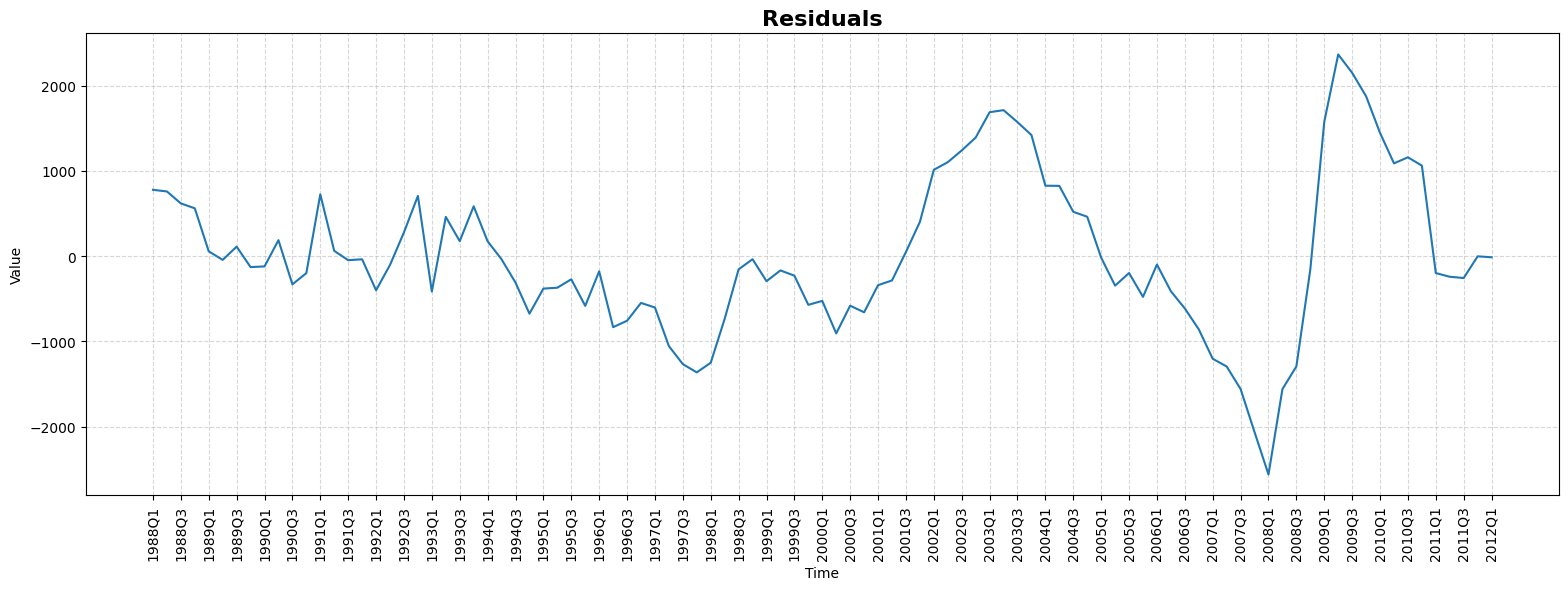

In [ ]:
#Plot aggregate consumption
plt.figure(figsize=(19, 6))

plt.plot(data['obs'], resid, label='Residuals')
plt.grid(True, linestyle='--', alpha=0.5)

#Add title and axis labels
plt.title('Residuals', fontsize=16, fontweight='bold')
plt.xlabel('Time')
plt.ylabel('Value')
plt.xticks(data['obs'][::2], rotation=90)
plt.savefig("/content/drive/MyDrive/EtricsIII_Ass2/Figures/Residuals.png")
plt.show()

In [ ]:
#Cointegration test
result = coint(data["INC"], data["CONS"], maxlag = 12, trend='ct', autolag = 'BIC')
result

(-3.6479164417228644,
 0.07009308607886727,
 array([-4.49231121, -3.88094886, -3.57086881]))

## Point 6

In [ ]:
# Collect in a dataframe DeltaY, Z_t-1 and DeltaX
adl_data = pd.DataFrame({"delta_x":x_T_first_diff_INC, "delta_y": x_T_first_diff_CONS, "z": resid.shift(1)})
adl_data = adl_data.drop(df.index[0])

In [ ]:
# Select optimal number of lags for Delta Y and for Delta X. Include constant and trend. Use bic as information criterion
#selected_model = ardl_select_order(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], maxlag=12, maxorder={"delta_x": 12, "z": 0}, missing="raise", ic="bic", trend = "n")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=4, order={"delta_x": 4, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 4, 0)   Log Likelihood                -647.259
Method:               Conditional MLE   S.D. of innovations            274.921
Date:                Thu, 11 Apr 2024   AIC                           1316.517
Time:                        19:20:02   BIC                           1344.257
Sample:                             4   HQIC                          1327.713
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L1    -0.1342      0.108     -1.240      0.218      -0.349       0.081
delta_y.L2     0.1717      0.095      1.809      0.074      -0.017       0.360
delta_y.L3     0.3935      0.096      4.086      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=4, order={"delta_x": 3, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 3, 0)   Log Likelihood                -647.268
Method:               Conditional MLE   S.D. of innovations            274.949
Date:                Thu, 11 Apr 2024   AIC                           1314.536
Time:                        19:22:26   BIC                           1339.754
Sample:                             4   HQIC                          1324.714
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L1    -0.1371      0.105     -1.305      0.196      -0.346       0.072
delta_y.L2     0.1699      0.093      1.820      0.072      -0.016       0.356
delta_y.L3     0.3922      0.095      4.119      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=4, order={"delta_x": 2, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 2, 0)   Log Likelihood                -647.269
Method:               Conditional MLE   S.D. of innovations            274.952
Date:                Thu, 11 Apr 2024   AIC                           1312.538
Time:                        19:22:37   BIC                           1335.234
Sample:                             4   HQIC                          1321.699
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L1    -0.1373      0.104     -1.314      0.192      -0.345       0.070
delta_y.L2     0.1701      0.093      1.833      0.070      -0.014       0.355
delta_y.L3     0.3933      0.091      4.313      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=4, order={"delta_x": 1, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 1, 0)   Log Likelihood                -647.803
Method:               Conditional MLE   S.D. of innovations            276.553
Date:                Thu, 11 Apr 2024   AIC                           1311.607
Time:                        19:22:44   BIC                           1331.781
Sample:                             4   HQIC                          1319.749
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L1    -0.1483      0.104     -1.428      0.157      -0.355       0.058
delta_y.L2     0.1400      0.088      1.597      0.114      -0.034       0.314
delta_y.L3     0.3663      0.087      4.209      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=4, order={"delta_x": 0, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 0, 0)   Log Likelihood                -647.845
Method:               Conditional MLE   S.D. of innovations            276.678
Date:                Thu, 11 Apr 2024   AIC                           1309.690
Time:                        19:22:59   BIC                           1327.343
Sample:                             4   HQIC                          1316.815
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L1    -0.1560      0.100     -1.568      0.121      -0.354       0.042
delta_y.L2     0.1321      0.083      1.601      0.113      -0.032       0.296
delta_y.L3     0.3715      0.085      4.393      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=[2,3,4], order={"delta_x": 0, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 0, 0)   Log Likelihood                -649.141
Method:               Conditional MLE   S.D. of innovations            280.604
Date:                Thu, 11 Apr 2024   AIC                           1310.282
Time:                        19:23:56   BIC                           1325.413
Sample:                             4   HQIC                          1316.389
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L2     0.1224      0.083      1.474      0.144      -0.043       0.287
delta_y.L3     0.3483      0.084      4.149      0.000       0.181       0.515
delta_y.L4     0.1448      0.082      1.762      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
mod = ARDL(endog = adl_data["delta_y"], exog = adl_data[["delta_x","z"]], lags=[3,4], order={"delta_x": 0, "z": 0}, missing="raise", trend="n")
results = mod.fit()
print(results.summary())

                              ARDL Model Results                              
Dep. Variable:                delta_y   No. Observations:                   96
Model:                  ARDL(4, 0, 0)   Log Likelihood                -650.276
Method:               Conditional MLE   S.D. of innovations            284.088
Date:                Thu, 11 Apr 2024   AIC                           1310.553
Time:                        19:24:16   BIC                           1323.162
Sample:                             4   HQIC                          1315.642
                                   96                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
delta_y.L3     0.3778      0.082      4.602      0.000       0.215       0.541
delta_y.L4     0.1918      0.076      2.516      0.014       0.040       0.343
delta_x.L0     0.1994      0.044      4.569      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [ ]:
print_res = summary_col([results],stars=True,float_format='%0.2f')
with open(path+'/Tables/part4.6_ECM.tex', 'w') as f:
  f.write(print_res.as_latex())
  f.close()